# Tarea Multi Layer Perceptron
Por Raziel Lopez Escamilla

Importamos librerias necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image,ImageOps
import os
import math
import json
from io import StringIO
import skimage as ski
from skimage import data, io, filters
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from skimage.measure import label, regionprops, regionprops_table
from skimage import data, filters, measure, morphology
from sklearn.neural_network import MLPClassifier

Cargamos las imagenes para entrenar y probar nuestro modelo

In [2]:
foto=os.path.join("images/foto(1).jpg")
figuras=os.path.join("images/figuras(1).jpg")
foto_image = Image.open(foto)
figuras_image = Image.open(figuras)

La imagenen a utilizar para el entrenamiento es la siguiente.

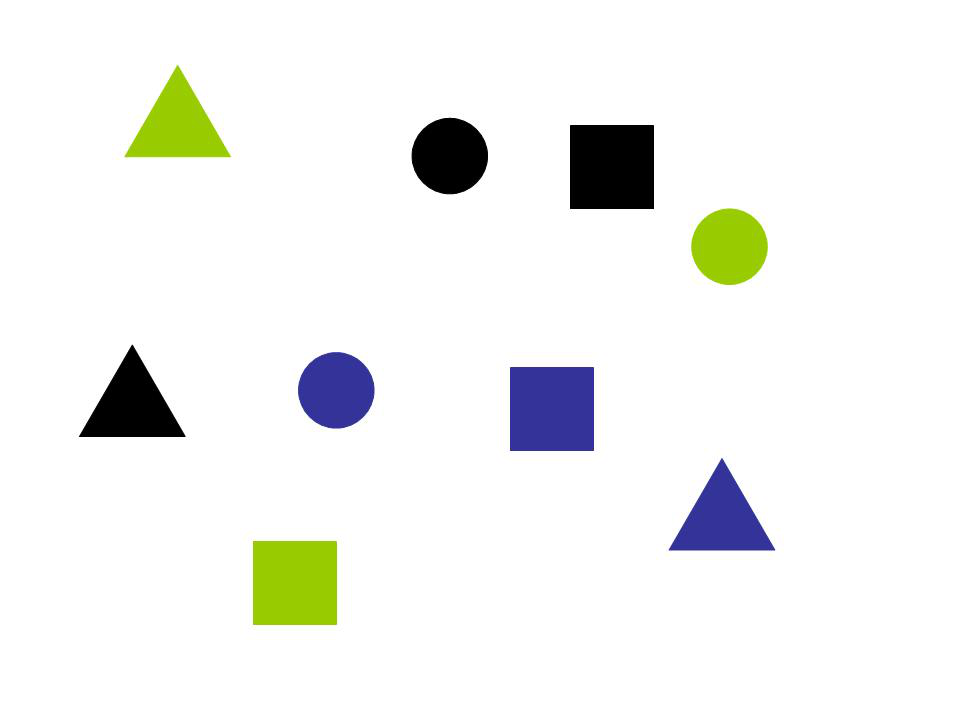

In [3]:
figuras_image

La imagenen a utilizar para el evaluar nuestras redes neuronales es la siguiente

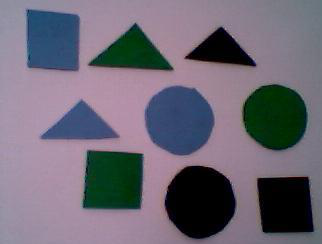

In [4]:
foto_image

## Clasificador de forma.

Convertimos imagenes a escala de grises para poder procesar mejor las imagenes

In [5]:
figuras_gray = figuras_image.convert('L')
foto_gray = foto_image.convert('L')

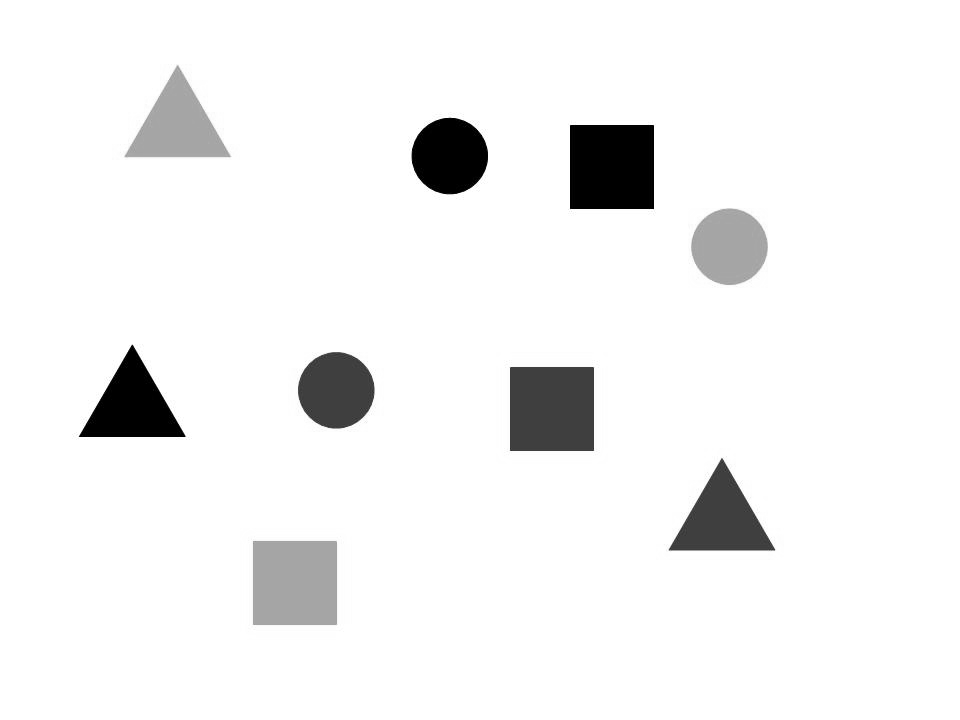

In [6]:
figuras_gray

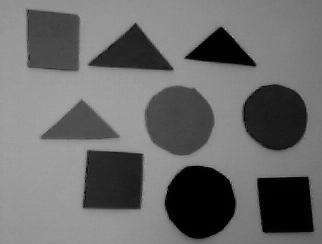

In [7]:
foto_gray

Definimos funciones que nos va a ayudar a obtener las regiones de la imagen en donde se encuentre una figura

In [8]:
def getImageRegions(img):
    img_gray = img.convert('L')
    img_array = np.array(img)

    img_gr_array = np.array(img_gray)
    
    #quitar componente alpha
    img_arrayRGB = np.array(img_array)[:,:,0:3]
    #invertimos valores de imagen
    img_inverted = ski.util.invert(img_gr_array)
    
    with np.nditer(img_inverted, op_flags=['readwrite']) as it:
        for x in it:
            if x > 50:
                x[...] = 255
    
    threshold = filters.threshold_otsu(img_inverted)
    mask = img_inverted > threshold

    mask = morphology.remove_small_objects(mask, 250)
    mask = morphology.remove_small_holes(mask, 250)

    img_labed = label(mask)
    img_regions = regionprops(img_labed)
    return img_regions

def getPictureRegions(img):
    img_gray = img.convert('L')
    img_array = np.array(img)

    img_gr_array = np.array(img_gray)
    
    #quitar componente alpha
    img_arrayRGB = np.array(img_array)[:,:,0:3]
    #invertimos valores de imagen
    img_inverted = ski.util.invert(img_gr_array)
    
    threshold = filters.threshold_otsu(img_inverted)
    print(threshold)
    mask = img_inverted > threshold

    mask = morphology.remove_small_objects(mask, 250)
    mask = morphology.remove_small_holes(mask, 250)

    img_labed = label(mask)
    img_regions = regionprops(img_labed)
    return img_regions


Definimos funcion para mostrar las regiones detectadas

In [9]:
def displayRegions(img, regions):
    plt.imshow(img,cmap='gray')

    for props in regions:

        y0, x0 = props.centroid
        orientation = props.orientation
        plt.plot(x0, y0, '.g', markersize=5)

        minr, minc, maxr, maxc = props.bbox
        margin = 0
        bx = (minc - margin , maxc + margin, maxc + margin, minc - margin, minc - margin)
        by = (minr - margin, minr - margin, maxr + margin, maxr+ margin, minr - margin)
        plt.plot(bx, by, '-b', linewidth=2.5)

    plt.show()

Obtenenemos las regiones en la imagen de las figuras, para posteriormente etiquetarlas de forma manual,
se grafican las regiones para corroborar.

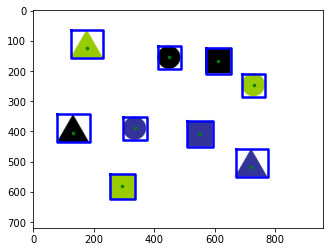

In [10]:
figuras_regions = getImageRegions(figuras_image)
displayRegions(figuras_image,figuras_regions)

Obtenemos momentos hu de cada una de las regiones encontradas y generamos el conjunto de datos de entrenamiento.

## Clasificador por forma

nuestro diccionario de etiquetas para la clasifiacion por forma es la siguiente:

* Cuadrado  = [1,0,0]
* Circulo   = [0,1,0]
* Triangulo = [0,0,1]

Ya que identificamos las regiones de interes, vamos a utilizar los momentos de hu para entrenar nuestro clasificador, cada forma identificadas fue previamente etiquetado y guardado en el archivo Train.json.

In [11]:
def getShapeData(regions,json_file):
    x = []

    #Get X values
    for region in regions:
        x.append(np.array(region.moments_hu))
        print("moments hu:", region.moments_hu)
        minr, minc, maxr, maxc = region.bbox
        
    x = np.array(x)
    
    #Get y values. For this we had to analyse the order in X values
    y = []
    with open(json_file) as data_file:    
        data = json.load(data_file)

    for fig in data:
        y.append(data[fig]["etiqueta_forma"])
    
    return x, y

In [12]:
x_train, y_train = getShapeData(figuras_regions,"Train.json");

moments hu: [ 1.92487441e-01  4.26447426e-08  4.57024393e-03  5.28962553e-09
 -2.29944891e-14 -1.08749157e-12 -1.21519515e-14]
moments hu: [ 1.59162002e-01  3.72657326e-08  8.69278990e-09  2.65069847e-12
 -4.01751430e-22 -4.23205271e-17  2.22102889e-23]
moments hu: [0.16664305 0.         0.         0.         0.         0.
 0.        ]
moments hu: [ 1.59161459e-01  9.04516458e-08  2.77886662e-08  3.14622926e-12
  4.01320177e-22 -1.74984582e-16  8.39276933e-22]
moments hu: [ 1.92433735e-01  8.74626685e-09  4.56078532e-03  3.92179883e-09
 -1.03035541e-15  2.33903276e-13 -1.65541995e-14]
moments hu: [ 1.59159517e-01  1.79469796e-08  1.60670103e-09  6.19799875e-13
  1.88279009e-23  4.03088672e-17 -5.29729254e-24]
moments hu: [0.16664305 0.         0.         0.         0.         0.
 0.        ]
moments hu: [ 1.92261785e-01  4.22874577e-08  4.53017404e-03  1.36617252e-09
  3.18816614e-15  2.52076558e-13 -1.17767323e-15]
moments hu: [0.16664305 0.         0.         0.         0.         0.

In [13]:
print("x train data:", x_train);
print("y train data:", y_train);

x train data: [[ 1.92487441e-01  4.26447426e-08  4.57024393e-03  5.28962553e-09
  -2.29944891e-14 -1.08749157e-12 -1.21519515e-14]
 [ 1.59162002e-01  3.72657326e-08  8.69278990e-09  2.65069847e-12
  -4.01751430e-22 -4.23205271e-17  2.22102889e-23]
 [ 1.66643046e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.59161459e-01  9.04516458e-08  2.77886662e-08  3.14622926e-12
   4.01320177e-22 -1.74984582e-16  8.39276933e-22]
 [ 1.92433735e-01  8.74626685e-09  4.56078532e-03  3.92179883e-09
  -1.03035541e-15  2.33903276e-13 -1.65541995e-14]
 [ 1.59159517e-01  1.79469796e-08  1.60670103e-09  6.19799875e-13
   1.88279009e-23  4.03088672e-17 -5.29729254e-24]
 [ 1.66643046e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.92261785e-01  4.22874577e-08  4.53017404e-03  1.36617252e-09
   3.18816614e-15  2.52076558e-13 -1.17767323e-15]
 [ 1.66643046e-01  0.00000000e+00  0.00000000e+00 

Creamos y ajustamos modelo

In [14]:
clf_forma = MLPClassifier(solver='lbfgs', alpha=1e-3,
                  hidden_layer_sizes=(10,3))

In [15]:
clf_forma.fit(x_train,y_train)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(10, 3), solver='lbfgs')

Obtenemos regiones de figura para imagen de prueba.

166


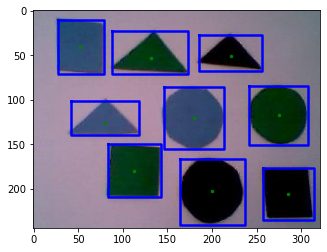

In [16]:
foto_regions = getPictureRegions(foto_image)

displayRegions(foto_image,foto_regions)

Con la informacion obtenida generamos un JSON que nos permita etiquetar las figuras para poder entrenar nuestra red neuronal.

In [17]:
x_test, y_test = getShapeData(foto_regions,"Test.json")

moments hu: [ 1.68621197e-01  6.20158613e-04  8.34711786e-06  2.69146925e-07
  1.83073624e-13 -3.74998103e-10 -3.59482939e-13]
moments hu: [ 2.19693668e-01  1.12609527e-02  5.33069618e-03  2.00354324e-04
 -1.60700445e-07 -1.78749246e-05 -1.30567966e-07]
moments hu: [ 2.20480103e-01  1.29730008e-02  4.78587936e-03  2.22880939e-04
 -1.23206425e-07 -1.67714297e-05  1.94444192e-07]
moments hu: [ 1.59546922e-01  8.93004395e-05  6.25132758e-06  4.36458653e-09
 -4.02693325e-16 -2.54298778e-11  5.97993782e-16]
moments hu: [ 1.59448424e-01  4.65015941e-05  1.72165424e-06  1.32864007e-09
 -5.51420644e-17 -8.78036091e-12  3.15811359e-17]
moments hu: [ 2.22367759e-01  1.38235114e-02  4.70869108e-03  2.17278609e-04
 -1.16012064e-07 -1.78953606e-05 -1.86659165e-07]
moments hu: [1.66265353e-01 2.21463042e-05 1.21591723e-05 2.75946081e-07
 1.51513091e-13 1.07249173e-09 4.82219277e-13]
moments hu: [ 1.59529132e-01  5.69102066e-05  4.65125431e-06  2.51591667e-09
  3.42976006e-17 -6.01428113e-12  2.69993

In [18]:
print("x test data:",x_test)
print("y tet data:", y_train);

x test data: [[ 1.68621197e-01  6.20158613e-04  8.34711786e-06  2.69146925e-07
   1.83073624e-13 -3.74998103e-10 -3.59482939e-13]
 [ 2.19693668e-01  1.12609527e-02  5.33069618e-03  2.00354324e-04
  -1.60700445e-07 -1.78749246e-05 -1.30567966e-07]
 [ 2.20480103e-01  1.29730008e-02  4.78587936e-03  2.22880939e-04
  -1.23206425e-07 -1.67714297e-05  1.94444192e-07]
 [ 1.59546922e-01  8.93004395e-05  6.25132758e-06  4.36458653e-09
  -4.02693325e-16 -2.54298778e-11  5.97993782e-16]
 [ 1.59448424e-01  4.65015941e-05  1.72165424e-06  1.32864007e-09
  -5.51420644e-17 -8.78036091e-12  3.15811359e-17]
 [ 2.22367759e-01  1.38235114e-02  4.70869108e-03  2.17278609e-04
  -1.16012064e-07 -1.78953606e-05 -1.86659165e-07]
 [ 1.66265353e-01  2.21463042e-05  1.21591723e-05  2.75946081e-07
   1.51513091e-13  1.07249173e-09  4.82219277e-13]
 [ 1.59529132e-01  5.69102066e-05  4.65125431e-06  2.51591667e-09
   3.42976006e-17 -6.01428113e-12  2.69993497e-16]
 [ 1.67232709e-01  4.66518834e-04  5.92204579e-06  

In [19]:
pred = clf_forma.predict(x_test)
pred

array([[0, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]])

Evaluamos desempeño de la red neuronal.

In [20]:
def ClassDetector(onehot):
    output=[]
    for caso in onehot:
        output.append(np.argmax(caso))
    return output

In [21]:
predclass=ClassDetector(pred)
yclass=ClassDetector(y_test)
print(predclass)
print(yclass)

[0, 2, 2, 1, 1, 2, 0, 1, 0]
[0, 2, 2, 1, 1, 2, 1, 2, 0]


In [22]:
print(accuracy_score(predclass,yclass)) 

0.7777777777777778


In [23]:
print(confusion_matrix(predclass,yclass))

[[2 1 0]
 [0 2 1]
 [0 0 3]]


## Clasificador por color 

nuestro diccionario de etiquetas para la clasifiacion por color es la siguiente:

* Verde  = [1,0,0]
* Negro   = [0,1,0]
* Azul = [0,0,1]

Ya que identificamos las regiones de interes, con ayuda de la coordenada del centroide vamos a obtener el color de cada figura, estos valores los vamos a utilizar para entrenar nuestro MLP, cada color identificado de las figuras fue previamente etiquetado y guardado en el archivo Train.json

In [24]:
def getColorData(regions,json_file,img):
    x = []

    #Get X values
    for reg in regions:
        y0, x0 = reg.centroid
        color = np.array(img)[int(y0),int(x0),0:3]
        print("centroide: ", reg.centroid, "color:", color)
        x.append(color)
    x = np.array(x)
    
    #Get y values. For this we had to analyse the order in X values
    y = []
    with open(json_file) as data_file:    
        data = json.load(data_file)

    for fig in data:
        y.append(data[fig]["etiqueta_color"])
    
    return x, y

x_train, y_train = getColorData(figuras_regions,"Train.json", figuras_image)

centroide:  (125.65209471766849, 177.20441206233556) color: [152 203   0]
centroide:  (155.57791225416037, 449.2515668899935) color: [0 0 0]
centroide:  (166.5, 611.5) color: [0 0 0]
centroide:  (246.25313117996046, 729.0129641836959) color: [152 203   0]
centroide:  (405.3281188118812, 131.85108910891088) color: [0 0 0]
centroide:  (389.90907122753845, 335.85516345529334) color: [ 52  51 153]
centroide:  (408.5, 551.5) color: [ 52  51 153]
centroide:  (519.1927379784102, 721.4995093228656) color: [ 52  51 153]
centroide:  (582.5, 294.5) color: [152 203   0]


In [25]:
print("x train data:", x_train);
print("y train data:", y_train);

x train data: [[152 203   0]
 [  0   0   0]
 [  0   0   0]
 [152 203   0]
 [  0   0   0]
 [ 52  51 153]
 [ 52  51 153]
 [ 52  51 153]
 [152 203   0]]
y train data: [[1, 0, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1], [1, 0, 0]]


Creamos y ajustamos modelo

In [26]:
clf_color = MLPClassifier(solver='lbfgs', alpha=1e-3,
                  hidden_layer_sizes=(10,3))

In [27]:
clf_color.fit(x_train,y_train)

/opt/anaconda3/envs/RNA/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=0.001, hidden_layer_sizes=(10, 3), solver='lbfgs')

In [28]:
x_test, y_test = getColorData(foto_regions,"Test.json", foto_image)

centroide:  (40.117914625612315, 52.42477256822953) color: [ 43  77 114]
centroide:  (52.94328358208955, 131.97611940298506) color: [ 1 60 16]
centroide:  (50.16792323509253, 220.76285126799178) color: [1 1 0]
centroide:  (116.79842473745624, 275.0399649941657) color: [ 0 40  4]
centroide:  (119.94977678571429, 179.27650669642858) color: [ 51  70 110]
centroide:  (125.41231593038822, 80.2764390896921) color: [ 62  81 123]
centroide:  (180.04770642201834, 112.97094801223241) color: [ 0 56 17]
centroide:  (201.72028313400048, 199.81401025140346) color: [0 0 0]
centroide:  (205.18242565987305, 285.1620447711326) color: [0 0 0]


In [29]:
print("x test data:", x_test);
print("y test data:", y_test);

x test data: [[ 43  77 114]
 [  1  60  16]
 [  1   1   0]
 [  0  40   4]
 [ 51  70 110]
 [ 62  81 123]
 [  0  56  17]
 [  0   0   0]
 [  0   0   0]]
y test data: [[0, 0, 1], [1, 0, 0], [0, 1, 0], [1, 0, 0], [0, 0, 1], [0, 0, 1], [1, 0, 0], [0, 1, 0], [0, 1, 0]]


In [30]:
pred2 = clf_color.predict(x_test)
pred2

array([[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

Evaluamos desempeño de la red neuronal.

In [31]:
predclass=ClassDetector(pred2)
yclass=ClassDetector(y_test)
print(predclass)
print(yclass)

[2, 0, 0, 0, 2, 2, 0, 0, 0]
[2, 0, 1, 0, 2, 2, 0, 1, 1]


In [32]:
print(accuracy_score(predclass,yclass)) 

0.6666666666666666


In [33]:
print(confusion_matrix(predclass,yclass))

[[3 3 0]
 [0 0 0]
 [0 0 3]]


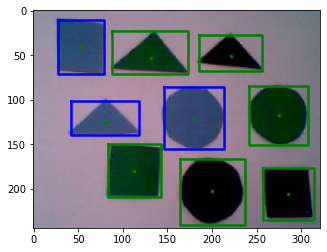

In [34]:
def getColorName(classification):
    color = '-m'
    if classification == 0:
        color = '-g' 
    if classification == 1:
        color = '-k'
    if classification == 2:
        color = '-b'
    return color
def showColorResults(img,regions, predclass):
    plt.imshow(img)
    indx = 0

    for r in regions:

        y0, x0 = r.centroid
        orientation = r.orientation
        plt.plot(x0, y0, '.g', markersize=5)

        minr, minc, maxr, maxc = r.bbox
        margin = 0
        bx = (minc - margin , maxc + margin, maxc + margin, minc - margin, minc - margin)
        by = (minr - margin, minr - margin, maxr + margin, maxr+ margin, minr - margin)
        color = getColorName(predclass[indx])
        plt.plot(bx, by, color , linewidth=2.5)
        indx += 1

    plt.show()

showColorResults(foto_image,foto_regions,predclass)

Con esos 2 clasificadores al unir ambas salidas podemos generar un dato que nos indique un color y forma para alguna entrada

In [35]:
print("Predicciones individuales:\n")
print("Prediccion en forma:\n",pred)
print("Prediccion en color:\n",pred2)

Predicciones individuales:

Prediccion en forma:
 [[0 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 0]
 [0 1 0]
 [0 0 0]]
Prediccion en color:
 [[0 0 1]
 [0 0 0]
 [1 0 0]
 [0 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 0]
 [1 0 0]
 [1 0 0]]


In [36]:
output = []
for i in range(len(pred)):
    output.append(np.concatenate((pred[i], pred2[i])))
print("Prediccion conjunta:\n",np.array(output))

Prediccion conjunta:
 [[0 0 0 0 0 1]
 [0 0 1 0 0 0]
 [0 0 1 1 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 1]
 [0 0 1 0 0 1]
 [0 0 0 0 0 0]
 [0 1 0 1 0 0]
 [0 0 0 1 0 0]]


## Conclusiones

Se pudo entrenar dos perceptrones multicapa, uno para clasificar por forma y otro por color, los resultados obtenidos NO fueron 100% precisos, es posible que esto se deba a diversos factores como el conjunto de datos de entrenamiento, la arquitectura de las redes y el número máximo de epocas, durante el desarrollo de la tarea notamos que la presición de los modelos variaba, esto se debe a la inicializacion de los pesos con valores aleatorios, entonces abra ocaciones en las que el modelo tenga una presición mayor al 60% y en otras tenga un porcentaje menor. En este caso, para poder lograr entrenar las redes neuronales es necesario tener conocimientos de vision por computadora, esto ayuda al momento de la extracción de características de los conjuntos de entrenamiento y de prueba.